In [2]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scienceplots
from tqdm import tqdm
import cmcrameri.cm as cmc
import cartopy.crs as ccrs

plt.style.use(['science'])

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [3]:
# data_path = Path(r"C:\Users\mathi\Danmarks Tekniske Universitet\Casper Tygesen Bang-Hansen - ProcessedGrids", "v6_mss21.nc")
data_path = Path(r"C:\Users\mathi\Danmarks Tekniske Universitet\Casper Tygesen Bang-Hansen - ProcessedGrids", "without_polar_v6_mss21.nc")
data = xr.load_dataset(data_path)

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xarray\backends\plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


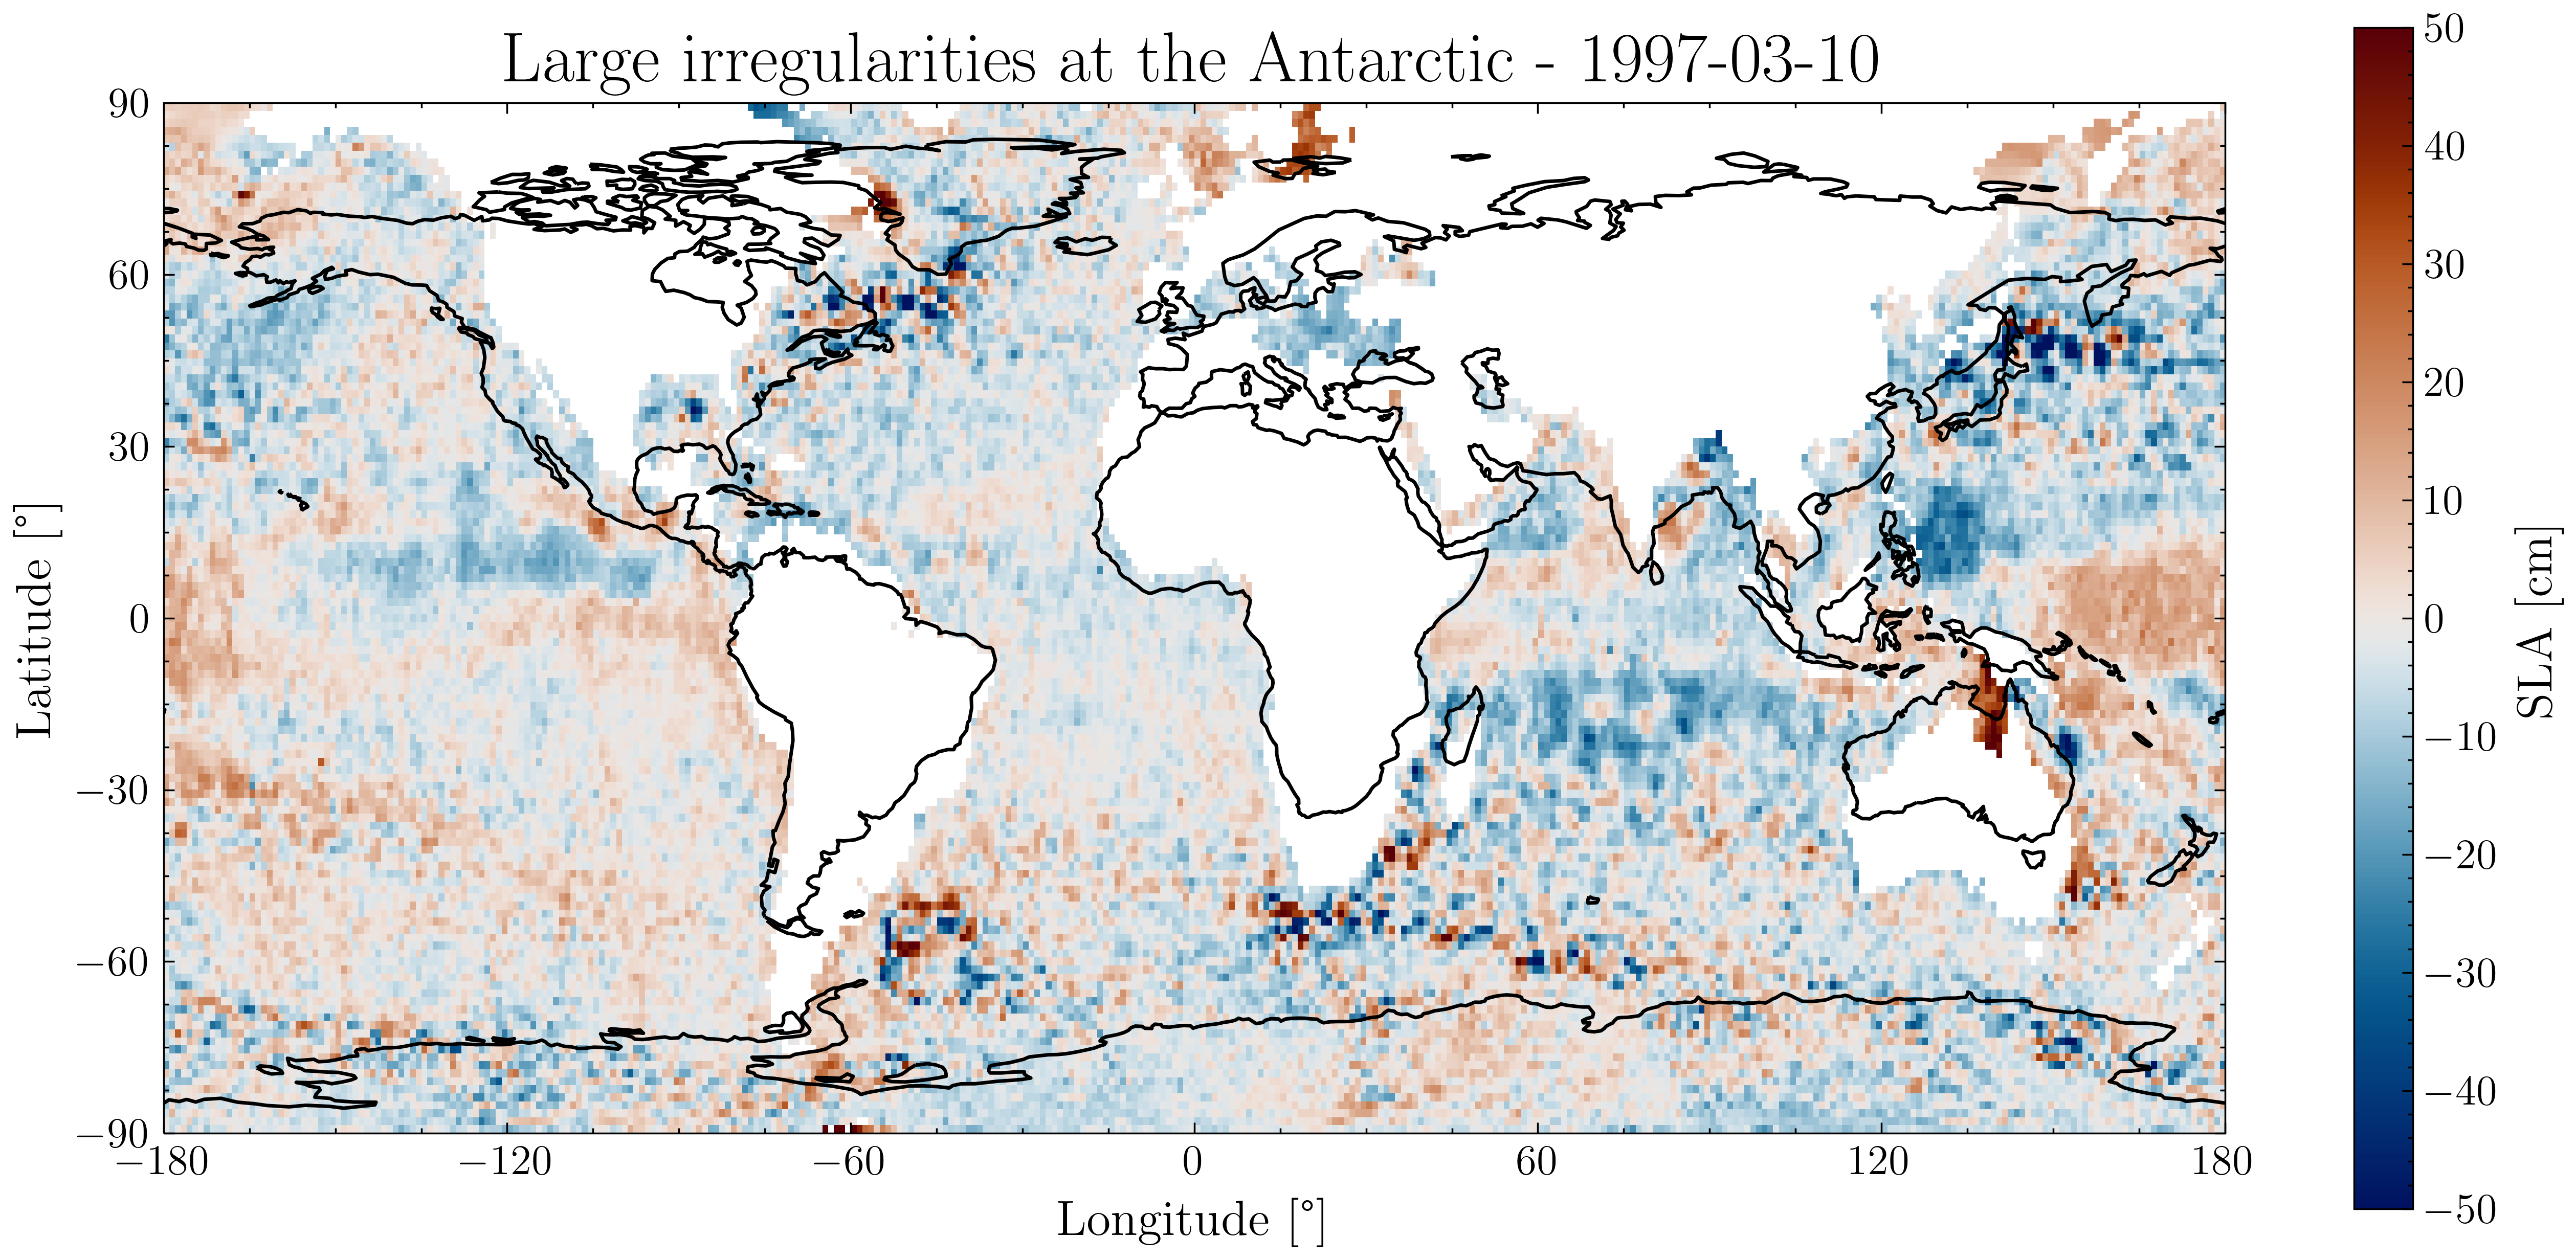

In [4]:
day = np.datetime64(f"1997-03-10T12:00:00.000000000")
# day = np.datetime64(f"2002-07-08T12:00:00.000000000")
# day = np.datetime64(f"2002-08-17T12:00:00.000000000")
bad_day = data.sla21.sel(time = (data.time >= day) & (data.time <= day+np.timedelta64(1)))[0]
vlim = 50

title_size = 20
label_size = 14
tick_size = 12

fig = plt.figure(figsize=(13,6), dpi=500)
ax = plt.axes(projection=ccrs.PlateCarree())
im=ax.imshow(bad_day*100, extent=[-180,180,-90,90], origin='lower', vmin=-vlim, vmax=vlim, cmap=cmc.vik)
ax.set_xlabel(f"Longitude [\N{DEGREE SIGN}]", fontsize=label_size)
ax.set_ylabel(f"Latitude [\N{DEGREE SIGN}]", fontsize=label_size)
ax.coastlines()
ax.set_extent([-180, 180, -90, 90])
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax.tick_params(labelsize=tick_size)
cbar = fig.colorbar(im, ticks=range(-vlim,vlim+10,10))
cbar.set_label("SLA [cm]", fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)
title_day = str(day).split("T")[0]
ax.set_title(f"Large irregularities at the Antarctic - {title_day}", fontsize=title_size)
plt.show()

In [5]:
# for i in range(9,13):
#     day = np.datetime64(f"1994-11-{i:02d}T12:00:00.000000000")
#     idx = np.where(data.sla21.time == day)[0][0]
#     d=data.sel(time = (data.time == day))
#     data["sla21"][idx] = np.full(data.sla21.shape[1:], np.nan)
#     data["sst"][idx] = np.full(data.sla21.shape[1:], np.nan)
#     data["swh"][idx] = np.full(data.sla21.shape[1:], np.nan)
#     data["wind_speed"][idx] = np.full(data.sla21.shape[1:], np.nan)

In [6]:
sla = data.sla21.sel(time = (data.time < np.datetime64("2005-01-01")) & (data.time > np.datetime64("1996-01-01")))#, lats = (np.abs(data.Latitude[:,0]) < 30))
times = sla.time
freq = np.fft.fftfreq(times.shape[-1], d=1/times.shape[-1])
idx = np.argsort(freq)

ffts = np.zeros(sla.shape, dtype=np.complex64)
for latidx in tqdm(sla.lats.values):
    for lonidx in sla.lons.values:
        cur_fft = np.fft.fft(sla[:, latidx, lonidx])
        ffts[:,latidx,lonidx] = cur_fft[idx]


100%|██████████| 129/129 [00:35<00:00,  3.60it/s]


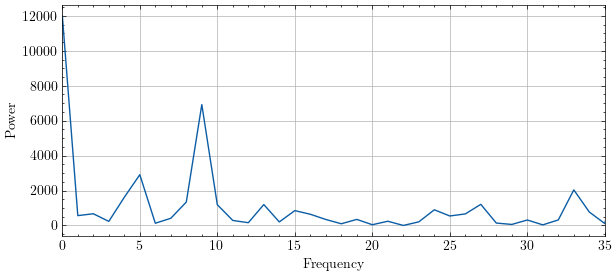

In [7]:
lat_idx, lon_idx = 0, 150

plt.figure(figsize=(7,3))
plt.plot(freq[idx], abs(ffts[:,lat_idx,lon_idx])**2)
plt.xlim([0,35])
plt.grid()
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()

In [8]:
power = abs(ffts)**2
power_sum = np.nanmax(power, axis=(0))

C:\Users\mathi\AppData\Local\Temp\ipykernel_23744\3466014119.py:2: RuntimeWarning: All-NaN slice encountered
  power_sum = np.nanmax(power, axis=(0))


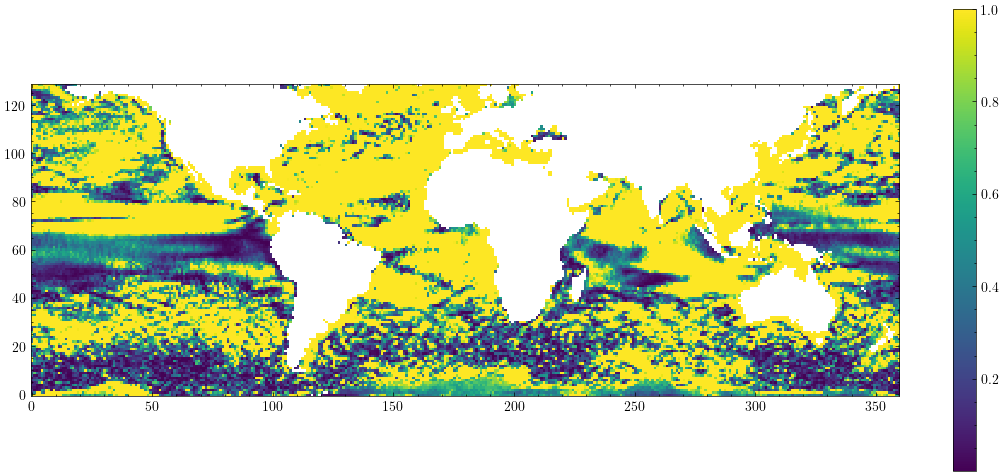

In [9]:
freq_idx = 9
bool_power = (freq[idx] == freq_idx)
normalized_power = (power[bool_power][0]/power_sum)
plt.figure(figsize=(14,6))
plt.imshow(normalized_power, origin="lower", vmax=1, interpolation="None")
plt.colorbar()
plt.show()

In [10]:
data["weighted_sla"] = data["sla21"] * np.cos(data["Latitude"]*np.pi/180)
truncated = data.weighted_sla.sel(time = (data.time < np.datetime64("1994-11-30")) & (data.time > np.datetime64("1994-10-01"))).sel(lats = np.abs(data.Latitude[:,0]) < 30)

In [11]:
# time_mean_weighted = data.weighted_sla.mean(dim=("lats", "lons"))
time_mean_weighted = truncated.mean(dim=("lats", "lons"))

In [12]:
sla_fft = np.fft.fft(time_mean_weighted.values)
freq = np.fft.fftfreq(time_mean_weighted.time.values.shape[-1], d=1/time_mean_weighted.time.values.shape[-1])
idx = np.argsort(freq)

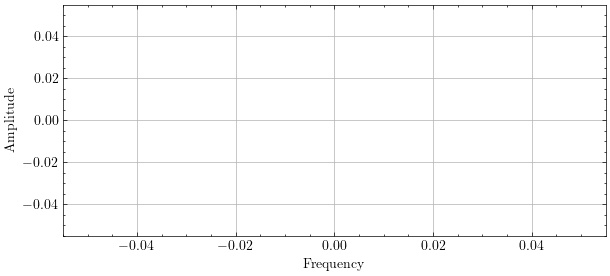

In [13]:
plt.figure(figsize=(7,3))
plt.plot(freq[idx], sla_fft.real[idx], freq[idx], sla_fft.imag[idx])
# plt.xlim([0,70])
plt.grid()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

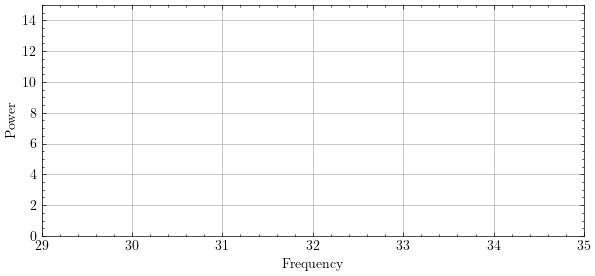

In [14]:
plt.figure(figsize=(7,3))
plt.plot(freq[idx], abs(sla_fft[idx])**2)
plt.xlim([29,35])
plt.ylim([0,15])
plt.grid()
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()

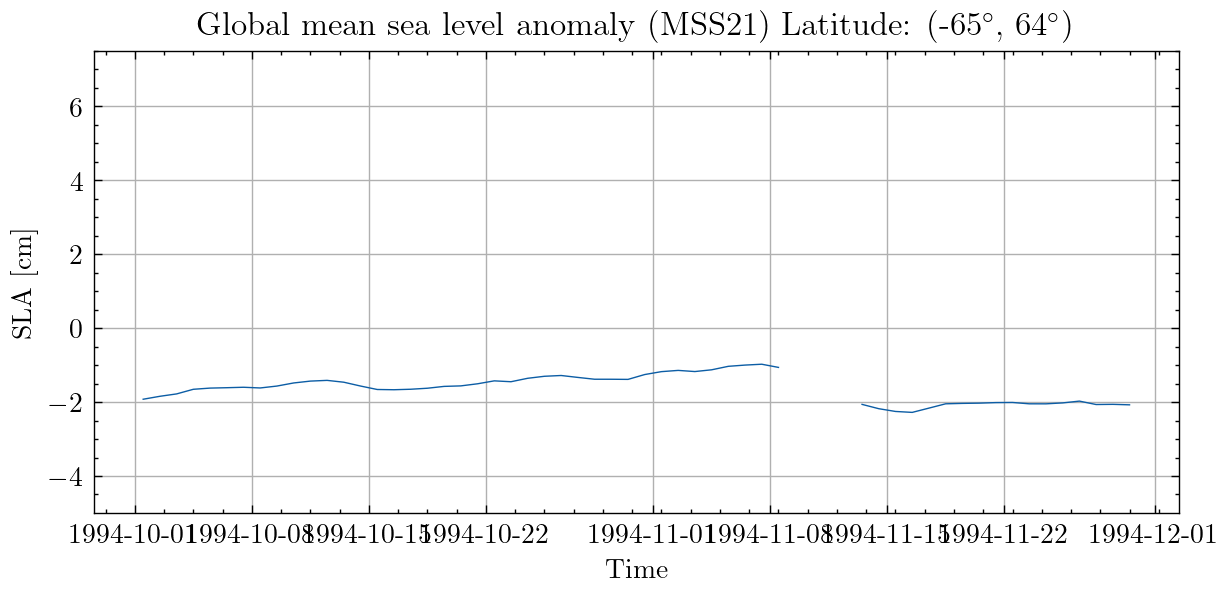

In [15]:
plt.figure(figsize=(7,3), dpi=200)
plt.plot(truncated.time, time_mean_weighted*100, linewidth=0.5)
plt.ylim([-5, 7.5])
plt.grid()
plt.xlabel("Time")
plt.ylabel("SLA [cm]")
plt.title("Global mean sea level anomaly (MSS21) Latitude: (-65$^\circ$, 64$^\circ$)")
plt.show()

In [17]:
fit_data = data["weighted_sla"]
X = np.full(fit_data.shape, np.nan)
for latidx in tqdm(data.lats):
    for lonidx in data.lons:
        x = fit_data[:,latidx, lonidx] * 100
        nan_mask = ~np.isnan(x)
        t = data.time.values.reshape(-1,1)[nan_mask].reshape(-1,1)
        t_lstsq = t.astype("datetime64[D]").astype(np.int32) / 365.25
        T = np.hstack([np.ones(t_lstsq.shape), t_lstsq, np.cos(2*np.pi*t_lstsq), np.sin(2*np.pi*t_lstsq)])
        m = np.linalg.lstsq(T,x[nan_mask], rcond=None)[0]
        X[:x[nan_mask].shape[0],latidx,lonidx] = T@m

  7%|▋         | 9/129 [00:25<06:01,  3.01s/it]

In [ ]:
X_mean = np.nanmean(X, axis=(1,2))

NameError: name 'np' is not defined

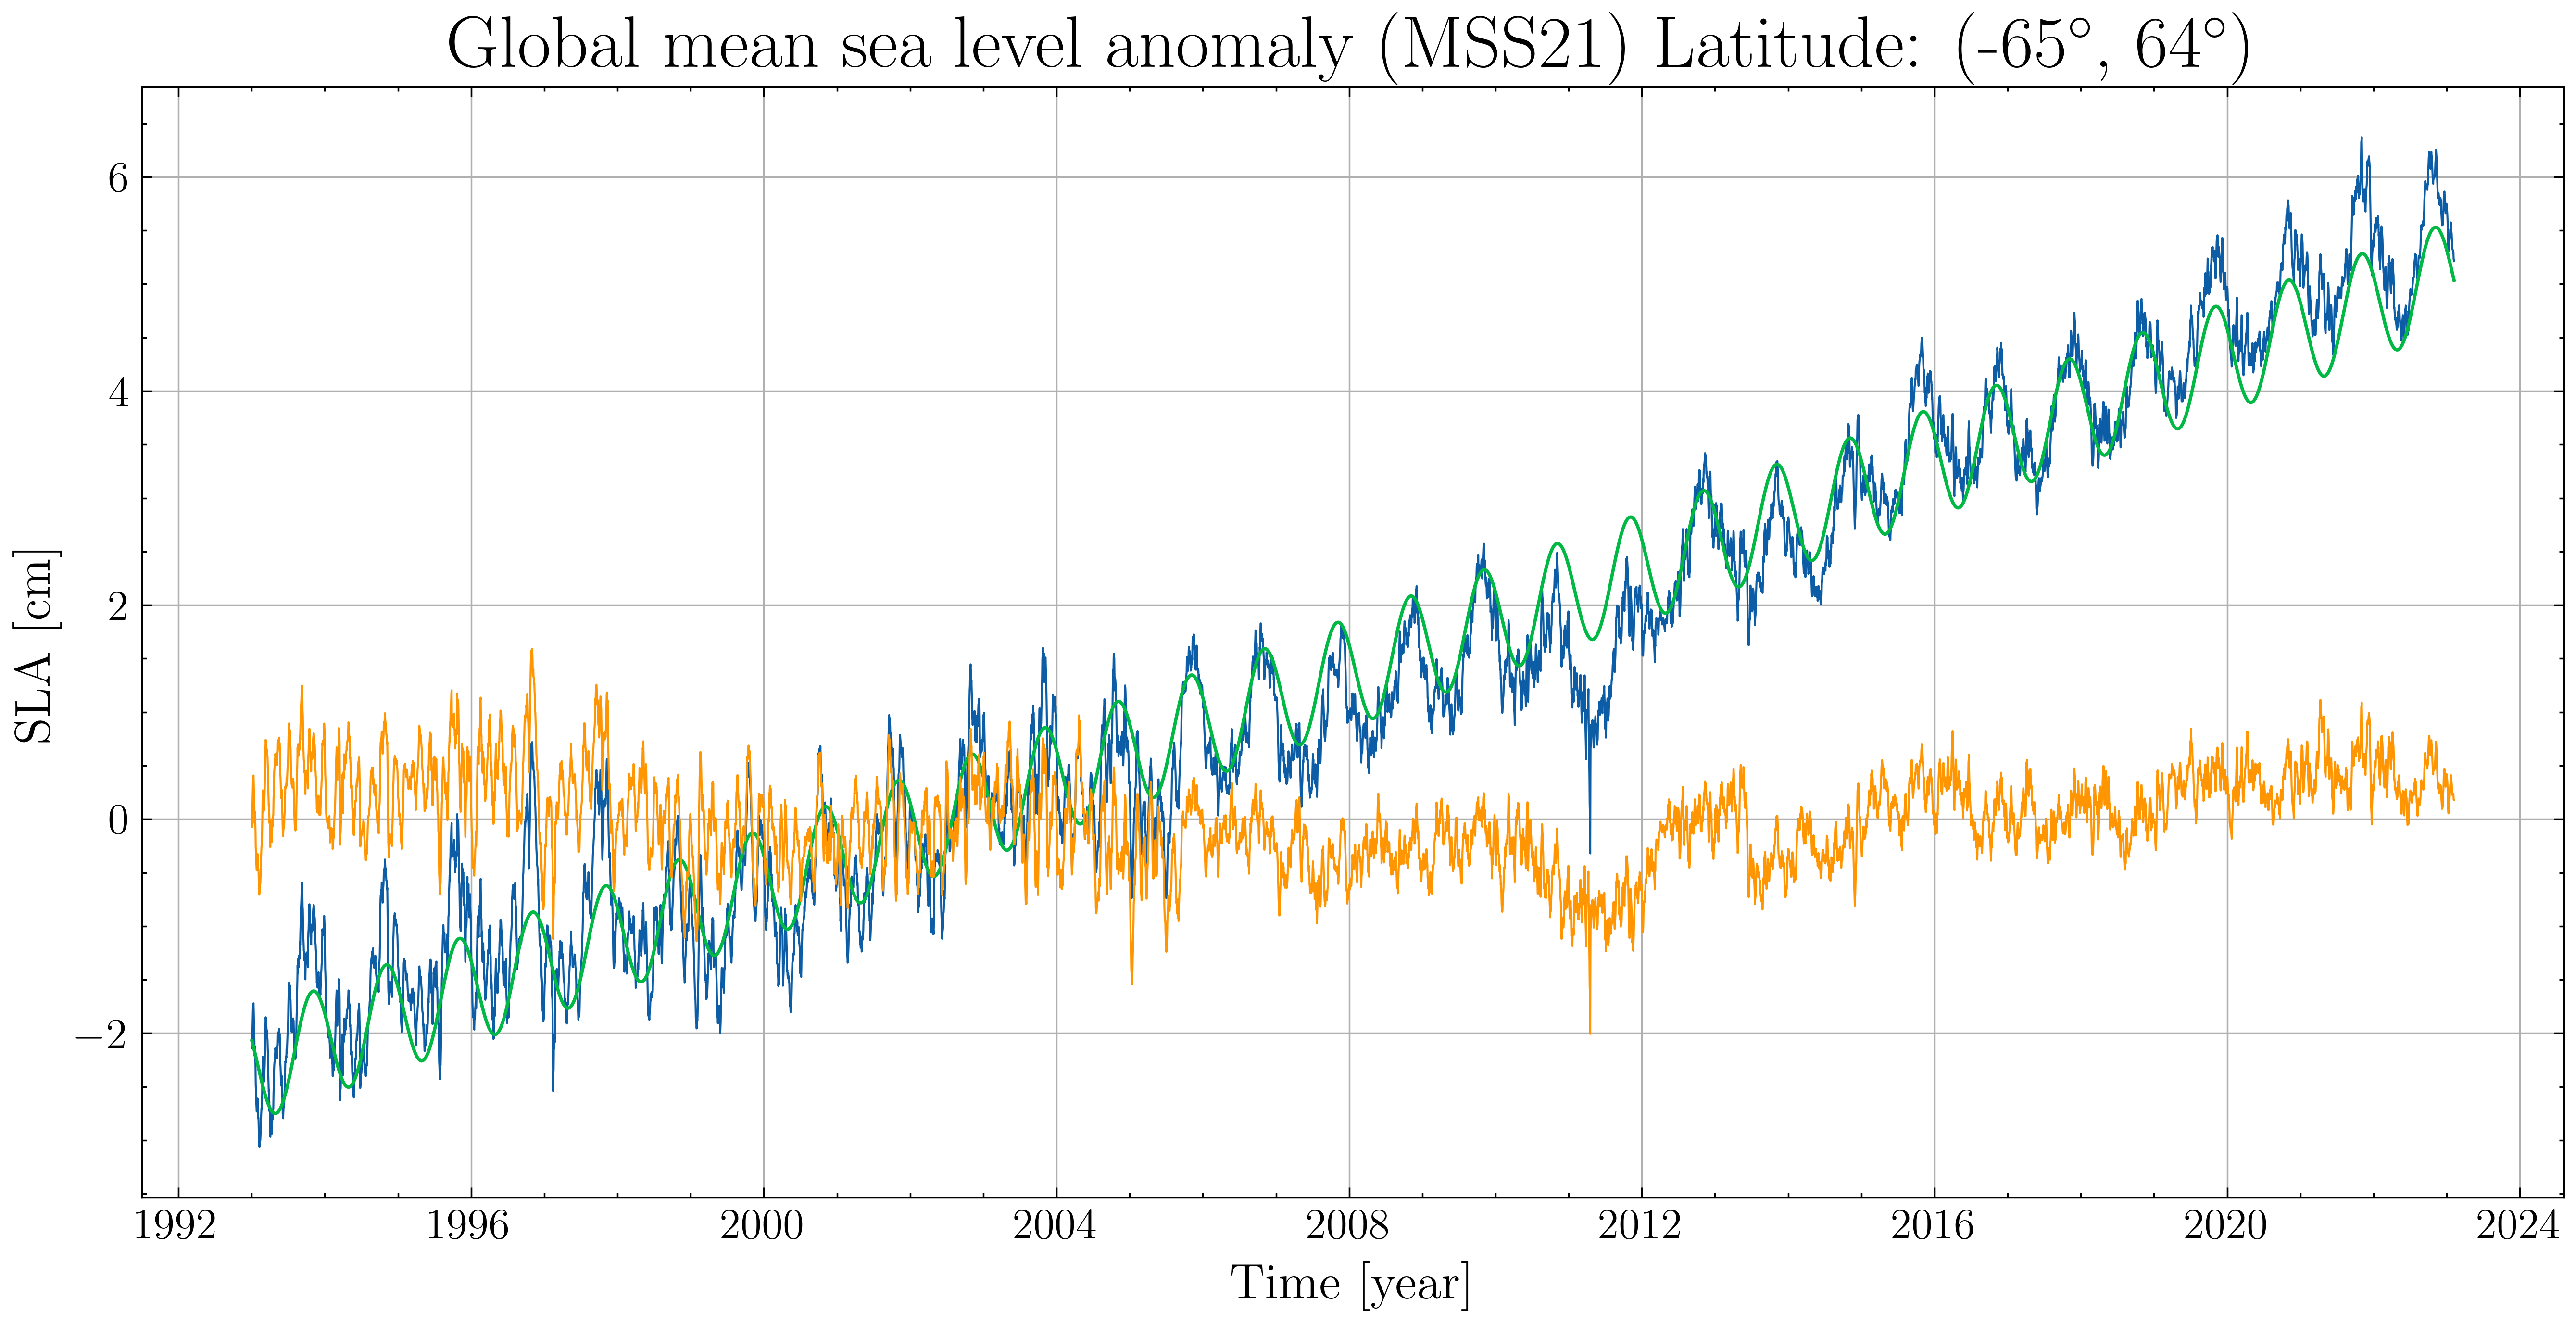

In [ ]:
title_size = 22
label_size = 15
tick_size = 13

plt.figure(figsize=(13,6), dpi=500)
plt.plot(t, x[nan_mask], linewidth=.6)
plt.plot(t, X_mean, linewidth=1)
plt.plot(t, x[nan_mask] - X_mean, linewidth=.6)
plt.grid()
plt.xlabel("Time [year]", fontsize=label_size)
plt.ylabel("SLA [cm]", fontsize=label_size)
plt.rc('xtick',labelsize=tick_size)
plt.rc('ytick',labelsize=tick_size)
plt.title("Global mean sea level anomaly (MSS21) Latitude: (-65$^\circ$, 64$^\circ$)", fontsize=title_size)
plt.show()